In [55]:
import math
import matplotlib.pyplot as plt
import random

In [106]:
class SignalGenerator:
    x_start: int = 0
    x_end: int = 100
    data: list[float] = []
    x_list: list[int] = []
    file_name: str = "out.txt"

    def __init__(self, x_start: int = 0, x_end: int = 100) -> None:
        self.x_start = x_start
        self.x_end = x_end
        self.set_x_list(x_start, x_end)

    def set_x_list(self, x_start: int, x_end: int):
        self.x_list = [x for x in range(self.x_start, self.x_end)]

    def sin(self, a: float = 1, b: float = 1) -> list[float]:
        self.data = [a * math.sin(x * b) for x in self.x_list]

    def square_vawe(self, frequency: int = 10, height: int = 1):
        self.data = [height if (x % frequency) >= (frequency / 2) else 0 for x in self.x_list]

    def triangle_vawe(self, p: float = 50):
        self.data = [2 * math.fabs((x / p) - math.floor((x / p) + 0.5)) for x in self.x_list]

    def noise(self, y_min: float = -1, y_max: float = 1):
        self.data = [random.uniform(y_min, y_max) for _ in self.x_list]

    def linear(self, a: float = 1, b: float = 1):
        self.data = [a * x + b for x in self.x_list]

    def const(self, value = 0) -> list[float]:
        self.data = [value for _ in self.x_list]

    def with_peaks(self):
        pass # todo
    def time_series(self):
        pass # todo
    def from_function(self, function):
        pass # todo
    def apply_noise(data):
        pass # todo

    def toFile(self):
        with open(self.file_name, 'w') as file:
            file.write(','.join(self.data))

    def draw(self):
        plt.plot(self.x_list, self.data)
        plt.show()

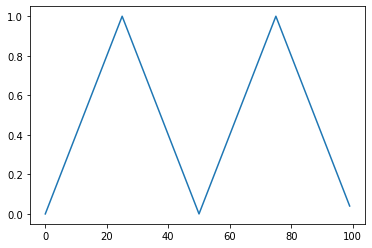

In [107]:
signal_generator = SignalGenerator()
signal_generator.triangle_vawe()
signal_generator.draw()